# Buck Stability Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import matplotlib.pyplot as plt


import numpy as np
import control
import json

import create_wc_component_v
alues

### Import the component values
Uncomment/comment the convertor you want/don't want to analyse

In [2]:
components = json.load(open("U8_values.json"))
#components = json.load(open("U10_values.json"))
#components = json.load(open("U11_values.json"))
#components = json.load(open("U11_values.json"))
#components = json.load(open("U16_chan2_values.json"))

### Create the equations

Whole transfer function from output voltage to error signal is given by:

$ H_{eo}(s) = - \frac{(1 + s R_3 C_3) \left[ 1 + s C_4 (R_4 + R_5) \right]}{s R_5 (C_2 + C_3) \left[ 1 + s R_3 \left( \frac{C_2 C_3}{C_2 + C_3} \right)\right] (1 +  s R_4 C_4) } $


Using the type III compensator:

<img src="vcm_comp.png">

In [3]:
def H_eo(values):
    # form the numerator
    num1 = control.tf([values['R3']*values['C3'], 1],[1])
    num2 = control.tf([values['C4']*(values['R4']+values['R5']), 1],[1])
    num = num1*num2

    # form the denominator
    den1 = control.tf([values['R5']*(values['C2']+values['C3']), 0],[1])
    den2 = control.tf([values['R3']*(values['C2']*values['C3']/(values['C2']+values['C3'])), 1],[1])
    den3 = control.tf([values['R4']*values['C4'], 1],[1])
    den = den1*den2*den3

    # form the transfer function
    return -num/den

Find the individual pole and zero locations

$ f_{p1} = 0 $

$ f_{p2} = \frac{1}{2 \pi R_4 C_4} $

$ f_{p3} = \frac{1}{2 \pi R_3 C_2} $

$ f_{z1} = \frac{1}{2 \pi R_3 C_3} $

$ f_{z2} = \frac{1}{2 \pi R_5 C_4} $

In [4]:
def f_p1(values):
    return 0

In [5]:
def f_p2(values):
    return 1/(2 * np.pi * values['R4'] * values['C4'])

In [6]:
def f_p3(values):
    return 1/(2 * np.pi * values['R3'] * values['C2'])

In [7]:
def f_z1(values):
    return 1/(2 * np.pi * values['R3'] * values['C3'])

In [8]:
def f_z2(values):
    return 1/(2 * np.pi * values['R5'] * values['C4'])

## Find the poles and zeros

In [9]:
# create dictionary with the nominal values
values = {}
for component in components.keys():
    values[component] = components[component]['nominal_value']

# manually add the inductor series resistance
values['L0_r'] = components['L0']['series_resistance']

# find poles and zeros
poles = [f_p1(values), f_p2(values), f_p3(values)]
zeros = [f_z1(values), f_z2(values)]

print("Poles: 1 = %0.3f kHz, 2 = %0.3f kHz, 3 = %0.3f kHz" % (poles[0]/1e3, poles[1]/1e3, poles[2]/1e3))
print("Zeros: 1 = %0.3f kHz, 2 = %0.3f kHz" % (zeros[0]/1e3, zeros[1]/1e3))

Poles: 1 = 0.000 kHz, 2 = 1415.717 kHz, 3 = 290386.336 kHz
Zeros: 1 = 3526.120 kHz, 2 = 7.092 kHz


## Find the transfer function
The equations used are:

$ H_{mod} = \frac{V_{in}}{V_{osc}} $

$ H_{out_filt} = \frac{1}{s^2 L_0 C_0 + s R{L_0} C_0 + 1 } $


In [10]:
def Ho(values):

    # get the transfer function from output voltage to error voltage
    Heo = H_eo(values)

    # get the modulator transfer function
    Vin = 12
    Vosc = 1.32
    Hmod = Vin/Vosc

    # get the output filter transfer function
    Hout_filt = control.tf([1],[values['L0']*values['C0'], values['C0']*values['L0_r'], 1])

    # calculate the full system transfer function
    return Hmod * Heo * Hout_filt

In [11]:
H = Ho(values)
print(H)



                    -9.254e-12 s^2 - 0.0002054 s - 9.091
---------------------------------------------------------------------------
3.519e-31 s^5 + 6.531e-22 s^4 + 5.847e-15 s^3 + 5.847e-10 s^2 + 5.781e-05 s



### Find the phase margin

In [12]:
margins = control.stability_margins(H)
print("Phase margin = %f " % (180+margins[1]))
print("Phase margin frequency = %0.1f kHz" % (1e-3*margins[4]/(2*np.pi)))

Phase margin = 20.305694 
Phase margin frequency = 31.9 kHz


## Plot the Bode plot

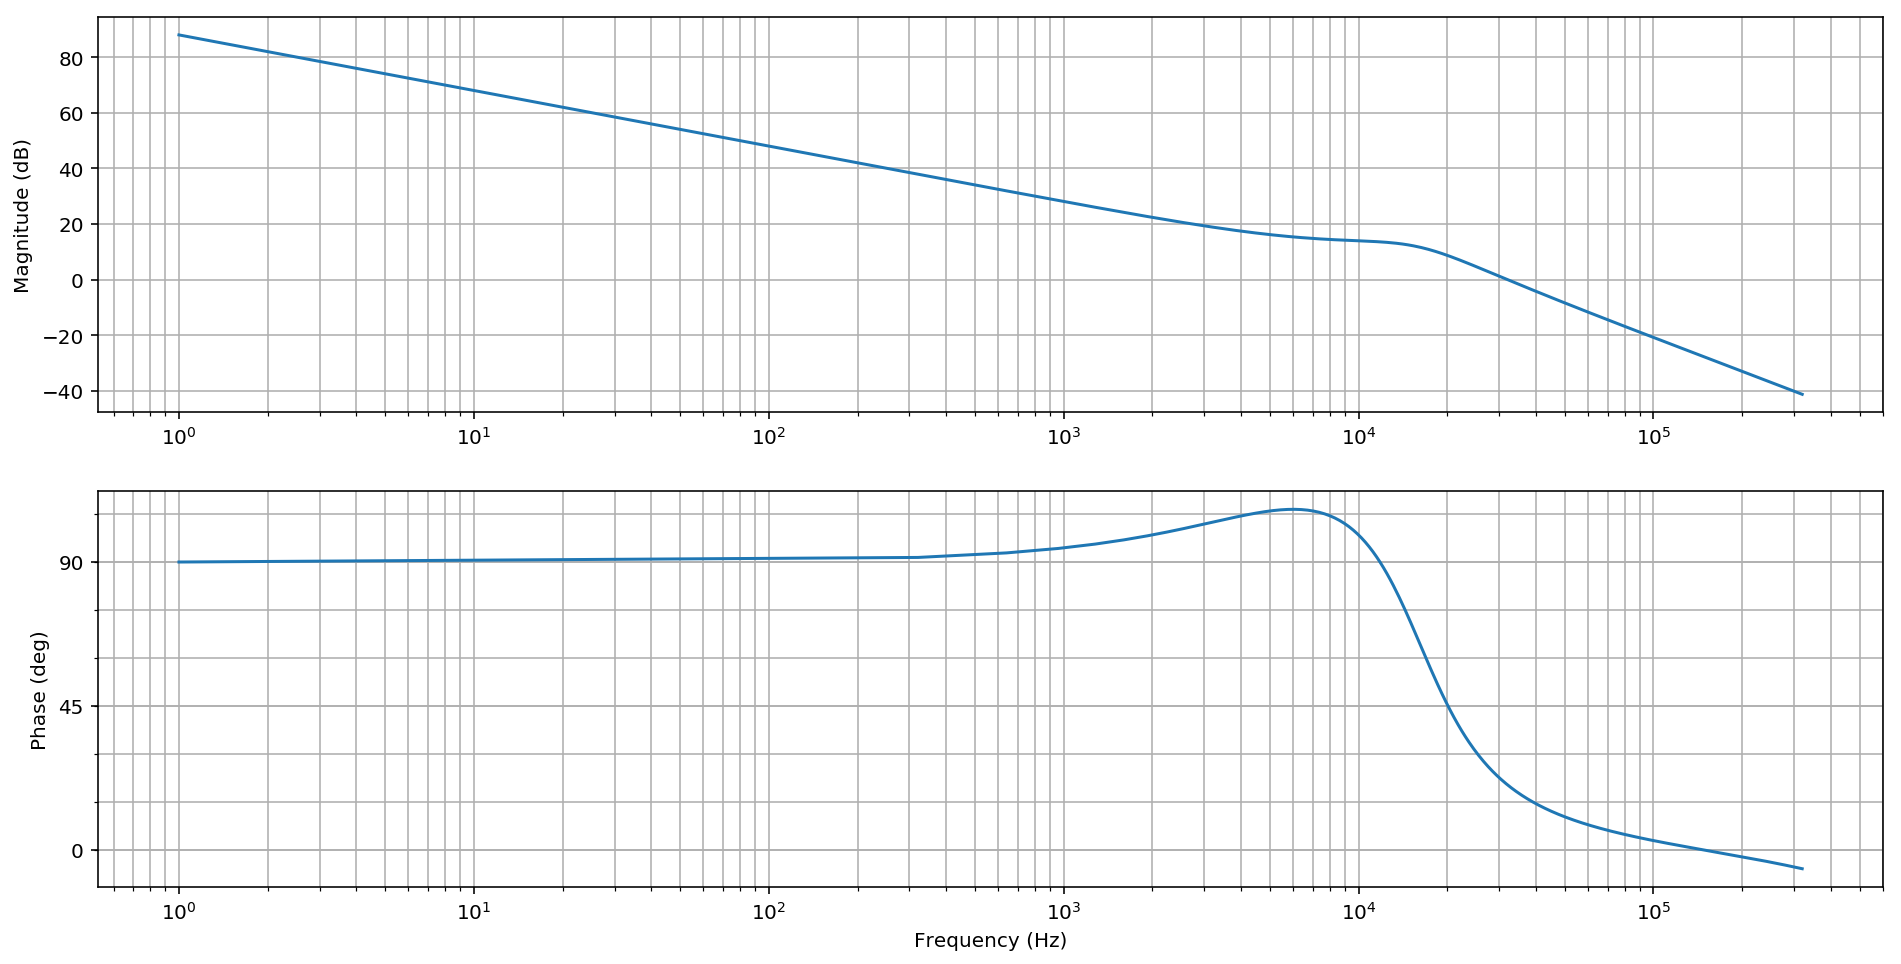

In [13]:
# create list of angular frequencies to perform analysis
w_list = np.linspace(2*np.pi*1, 10*margins[4], 1000)

# increase the size of the plot
plt.rcParams["figure.figsize"] = (16,8)

# plot the bode plot
mag, phase, omega = control.bode_plot(H, omega=w_list, dB=True, Hz=True)

## Perform Analysis Over Worst Case Conditions

In [14]:
wc_values = create_wc_component_values.create_wc_component_values(components)

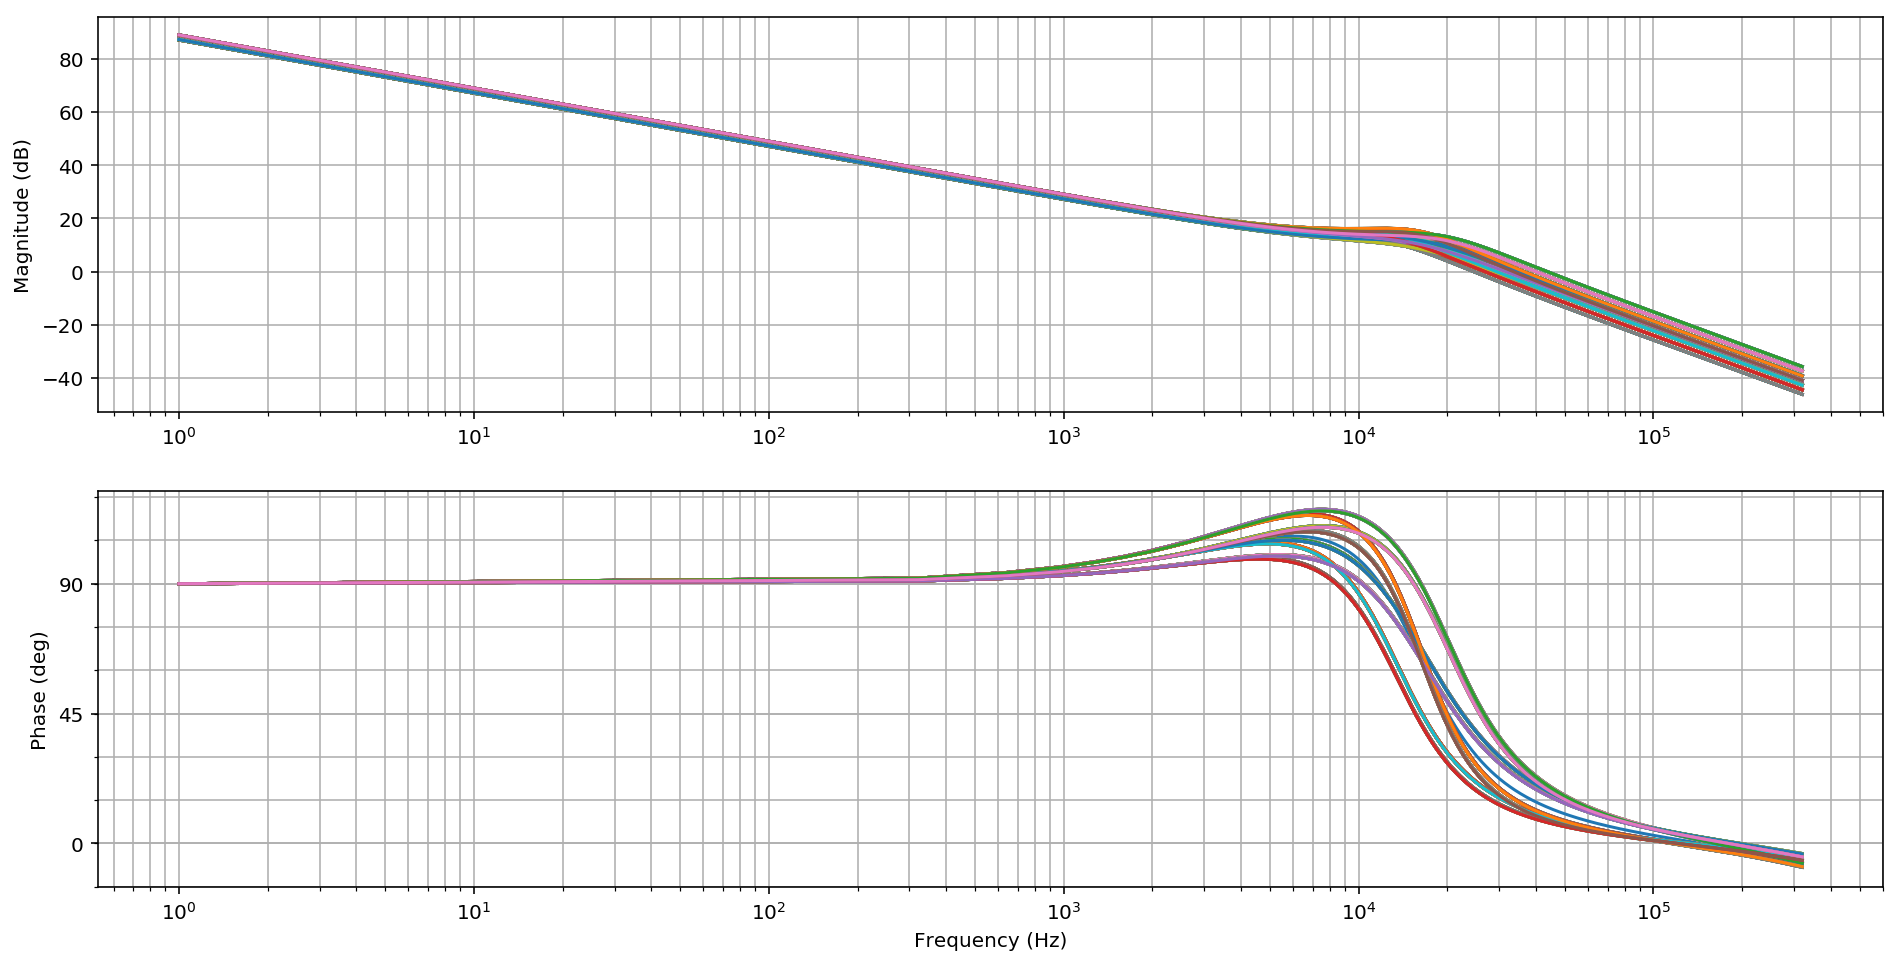

In [15]:
phase_margins = []
for i_values in wc_values:
    Hi = Ho(i_values)
    phase_margins.append(180+control.stability_margins(Hi)[1])
    control.bode_plot(Hi, omega=w_list, dB=True, Hz=True)

### Plot the Phase Margin

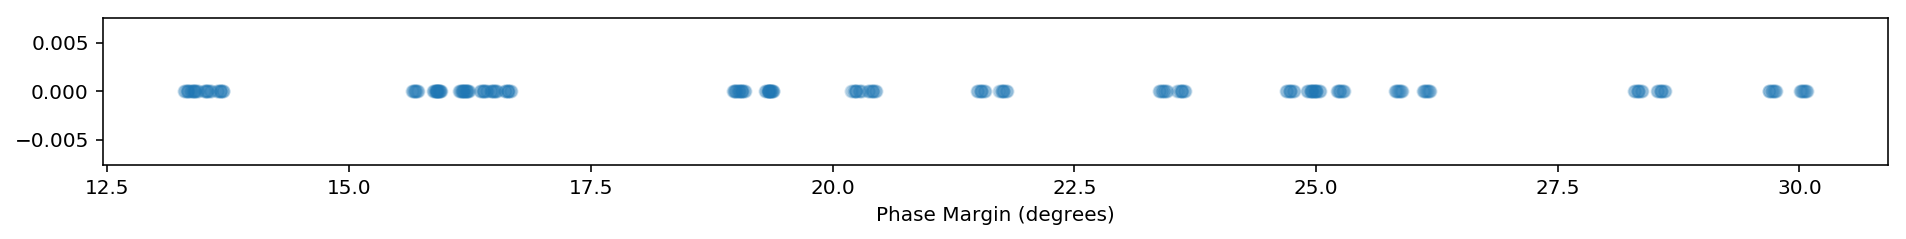

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(phase_margins,[0]*len(phase_margins), alpha=0.2)
ax.set_aspect(aspect=100)
plt.xlabel('Phase Margin (degrees)')
plt.show()